In [143]:
import pandas as pd
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC

In [144]:
real_data = pd.read_csv("dataset_1.csv")

In [145]:
X = real_data.drop("SARS-Cov-2 exam result", axis = 1)
y = real_data["SARS-Cov-2 exam result"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [146]:
categorical_features = [col for col in X.columns if X[col].nunique() <= 2]

smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)

X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

print("Original class distribution:", y_train.value_counts())
print("Resampled class distribution:", pd.Series(y_resampled).value_counts())

Original class distribution: SARS-Cov-2 exam result
0    415
1     66
Name: count, dtype: int64
Resampled class distribution: SARS-Cov-2 exam result
0    415
1    415
Name: count, dtype: int64


In [147]:
resampled_data = pd.concat([X_resampled, y_resampled], axis=1)

last_column = resampled_data.columns[-1]
new_order = [resampled_data.columns[0]] + [last_column] + list(resampled_data.columns[1:-1])

resampled_data = resampled_data[new_order]

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=real_data)

synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(real_data)
synthetic_data = synthesizer.sample(num_rows = int(len(real_data) * 0.2))

/home/codespace/.python/current/lib/python3.12/site-packages/sdv/single_table/base.py:119: FutureWarning:

The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.

/home/codespace/.python/current/lib/python3.12/site-packages/sdv/single_table/base.py:104: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



In [148]:
final_data = pd.concat([resampled_data, synthetic_data], ignore_index=True)
final_data.sample(frac=1, random_state=42).reset_index(drop=True)
final_data.to_csv("final_data.csv", index=False)

In [149]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data,
    synthetic_data,
    metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 20/20 [00:00<00:00, 840.01it/s]|
Column Shapes Score: 89.24%

(2/2) Evaluating Column Pair Trends: |██████████| 190/190 [00:00<00:00, 230.59it/s]|
Column Pair Trends Score: 86.4%

Overall Score (Average): 87.82%



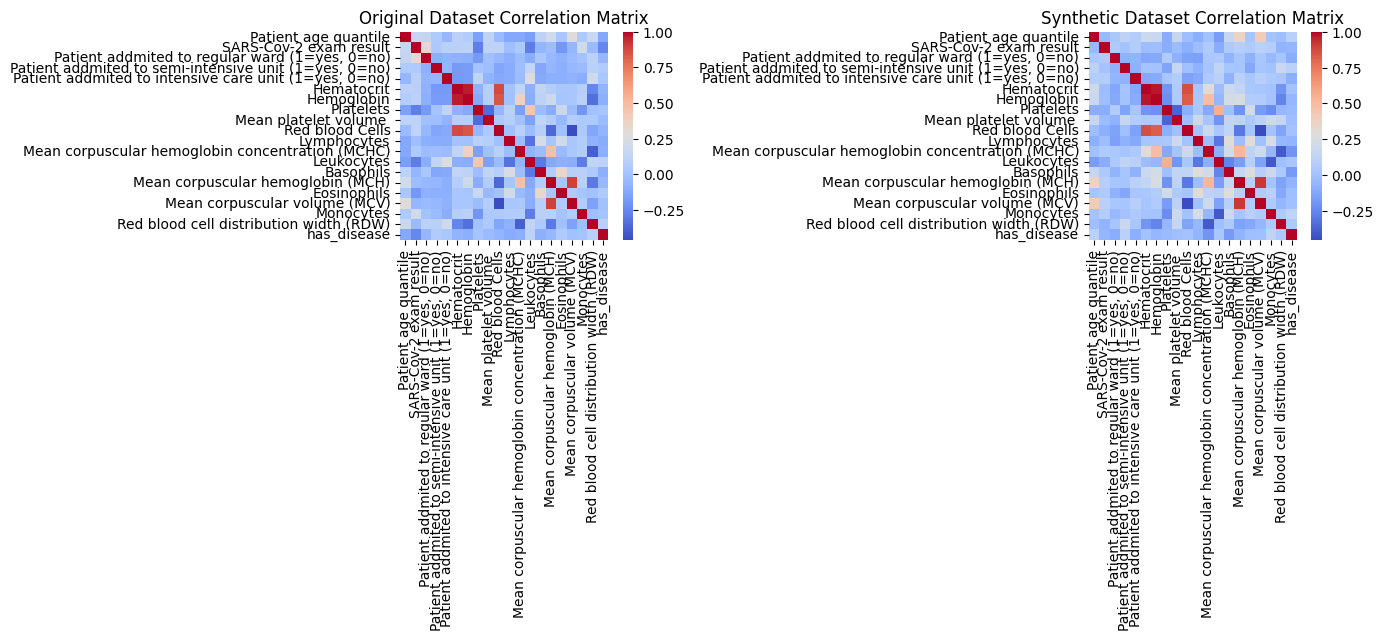

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

original_corr = real_data.corr()
synthetic_corr = synthetic_data.corr()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(original_corr, annot=False, cmap="coolwarm", cbar=True, square=True)
plt.title("Original Dataset Correlation Matrix")

plt.subplot(1, 2, 2)
sns.heatmap(synthetic_corr, annot=False, cmap="coolwarm", cbar=True, square=True)
plt.title("Synthetic Dataset Correlation Matrix")

plt.tight_layout()
plt.show()

In [151]:
from scipy.stats import ks_2samp, chi2_contingency
import seaborn as sns

# --- Validation: Kolmogorov-Smirnov (K-S) Test for Continuous Features ---
ks_test_results = {}
chi_square_results = {}

for column in real_data.columns:
    unique_values = real_data[column].nunique()

    if unique_values <= 2: 
        observed = synthetic_data[column].round().value_counts().sort_index()
        expected = real_data[column].round().value_counts().sort_index()

        # Align indices in case categories differ
        all_categories = set(observed.index).union(set(expected.index))
        observed = observed.reindex(all_categories, fill_value=0)
        expected = expected.reindex(all_categories, fill_value=0)

        chi2, p_value, _, _ = chi2_contingency([observed, expected])
        chi_square_results[column] = {"Chi2": chi2, "P-Value": p_value}
    
    else:
        ks_statistic, p_value = ks_2samp(real_data[column], synthetic_data[column])
        ks_test_results[column] = {"KS Statistic": ks_statistic, "P-Value": p_value}

# Display K-S Test results for continuous features
ks_test_df = pd.DataFrame(ks_test_results).T
print("\nKolmogorov-Smirnov Test Results for Continuous Features:")
print(ks_test_df)

# Display Chi-Square Test results for discrete features
chi_square_results_df = pd.DataFrame(chi_square_results).T
print("\nChi-Square Test Results for Discrete Features:")
print(chi_square_results_df)


Kolmogorov-Smirnov Test Results for Continuous Features:
                                                  KS Statistic       P-Value
Patient age quantile                                  0.078599  5.378279e-01
Hematocrit                                            0.117331  1.161203e-01
Hemoglobin                                            0.112569  1.449227e-01
Platelets                                             0.076412  5.712878e-01
Mean platelet volume                                  0.088953  3.816182e-01
Red blood Cells                                       0.112486  1.455523e-01
Lymphocytes                                           0.136351  4.345024e-02
Mean corpuscular hemoglobin concentration (MCHC)      0.082530  4.738566e-01
Leukocytes                                            0.115061  1.293615e-01
Basophils                                             0.465781  3.172952e-20
Mean corpuscular hemoglobin (MCH)                     0.110354  1.608017e-01
Eosinophils       

In [152]:
from sdv.evaluation.single_table import get_column_plot

for column in real_data.columns:
    fig = get_column_plot(
        real_data=real_data,
        synthetic_data=synthetic_data,
        column_name=column,
        metadata=metadata
    )
    fig.show()